# PLAN

- [x] Acquisition
    - [x] Select what list of repos to scrape.
    - [x] Get requests from the site.
    - [x] Save responses to csv.
- [x] Preparation
    - [x] Prepare the data for analysis.
- [x] Exploration
    - [x] Answer the following prompts:
        - [x] What are the most common words in READMEs?
        - [x] What does the distribution of IDFs look like for the most common words?
        - [x] Does the length of the README vary by language?
        - [x] Do different languages use a different number of unique words?
- [x] Modeling
    - [x] Transform the data for machine learning; use language to predict.
    - [x] Fit several models using different text representations.
    - [x] Build a function that will take in the text of a README file, and makes a prediction of language.
- [ ] Delivery
    - [ ] Github repo
        - [x] This notebook.
        - [x] Documentation within the notebook.
        - [x] README file in the repo.
        - [x] Python scripts if applicable. (We've decided to self-contain in ipynb only.)
    - [ ] Google Slides
        - [ ] 1-2 slides only summarizing analysis.
        - [ ] Visualizations are labeled.
        - [ ] Geared for the general audience.
        - [ ] Share link @ readme file and/or classroom.

# ENVIRONMENT

In [1]:
import os
import sys

import pandas as pd
import re
import json
import unicodedata
import nltk
import spacy
import random
random.seed(493)

from requests import get
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# Removed python and javascript as stopwords because these words DO ADD meaning to the text.
# ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-', 'python', 'javascript']
ADDITIONAL_STOPWORDS = ['readme', '\n\n\n', '-PRON-']

# ACQUIRE

In [2]:
# We have decided to search Github for repositories
# associated with the Texas Tribune newspaper.
# From this organization, we will scrape the results of the repositories' README files. 
# https://github.com/texastribune

In [3]:
def get_github_repo(url):
    """
    This function takes a url and returns a dictionary that
    contains the content and language of the readme file.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    readme = soup.find('div', id='readme')
    language = soup.find('span', class_='lang')
    
    d = dict()
    if readme is None:
        d['readme'] = 'No readme file.'
    else:
        d['readme'] = readme.text
    if language is None:
        d['language'] = 'No language specified.'
    else:
        d['language'] = language.text
    return d

In [4]:
# # This line to test out the function to scrape one repo.
# get_github_repo('https://github.com/open-austin/atx-citysdk-js')

In [5]:
def get_github_links(url):
    """
    This function takes in a url and returns a list of links
    that comes from each individual repo listing page.
    """
    response = get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = []
    for link in soup.findAll('a', itemprop='name codeRepository', attrs={'href': re.compile("^/")}):
        links.append(link.get('href'))
    return links

In [6]:
# # This line to test out the function.
# get_github_links('https://github.com/open-austin?page=3')

In [7]:
def get_all_github_links(path, num_pages):
    """
    This function takes in a url path and number of pages
    and returns a list of lists of all links.
    """
    all_links = []
    for i in range(num_pages):      # Number of pages plus one
        page = i + 1
        response = get(path + str(page))
        soup = BeautifulSoup(response.text, 'html.parser')
        all_links.append(get_github_links(path + '?page=' + str(page)))
    return all_links

In [8]:
# # This line to test out the function.
# get_all_github_links('https://github.com/open-austin', 3)

In [9]:
def traverse(o, tree_types=(list, tuple)):
    if isinstance(o, tree_types):
        for value in o:
            for subvalue in traverse(value, tree_types):
                yield subvalue
    else:
        yield o

In [10]:
def get_github_readme(url, num_pages, cache=True):
    if cache and os.path.exists('github_readme.json'):
        readme_text = json.load(open('github_readme.json'))
    else:
        data = get_all_github_links(url, num_pages)
        readme_text = []
        for value in traverse(data):
            print('https://github.com'+value)
            readme_text.append(get_github_repo('https://github.com' + value))
        json.dump(readme_text, open('github_readme.json', 'w'))
    return readme_text

In [11]:
# Bringing it all together chaining...
from pprint import pprint
corpus = get_github_readme('https://github.com/texastribune', 8, cache=True)
pprint(corpus)

[{'language': 'Dockerfile',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Base images\n'
            'How to make updates:\n'
            '\n'
            'Create a new branch\n'
            "If you're adding a python dependency:\n"
            '\n'
            'Run make run-base\n'
            "Run poetry add --dev <package> (drop the --dev if it's a "
            'production\n'
            'dependency)\n'
            'For other operations see the\n'
            'poetry docs\n'
            'Maybe edit pyproject.toml by hand if necessary\n'
            'Run poetry lock\n'
            '\n'
            '\n'
            "If it's a node dependency:\n"
            '\n'
            'Run make run-dev\n'
            'Do whatever node/yarn things you people do ;-)\n'
            '\n'
            '\n'
            'Bump the version in VERSION file\n'
            'Bump vers

            'provide a sane\n'
            'fallback.\n'
            'The WellManager has a convenience method, get_current, that takes '
            'in a WellType\n'
            'name and fetches the Well associated with that WellType, has the '
            'most recent\n'
            "pub_date in the past and doesn't have an expires in the past.\n"
            '\n'
            'Using a QuerySetBackedWellView\n'
            'Wells can also be backed by a queryset which will be used as a '
            'source of\n'
            'additional content after all items have been exhausted. '
            'Currently, this is not\n'
            'configurable via the admin, but can be easily accomplished by '
            'using the\n'
            'QuerySetBackedWellView. For example, in a urls.py:\n'
            "url(r'^$', "
            "QuerySetBackedWellView.as_view(well_title='front_page',\n"
            '                                          '
            'template_name="index.html",\n'

            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Analysis of maternal mortality data\n'
            'This repo contains data, code and analyis supporting the Texas '
            "Tribune's maternal mortality project. We used two main analysis "
            'in the story:\n'
            '\n'
            'The mortality and prenatal rates in rural counties v. urban '
            'counties in Texas for 2010-14.\n'
            'The mortality and prenatal rate for counties with at least one '
            'hospital with an obstetric bed v. those that did not have one. '
            'This was for 2014.\n'
            '\n'
            'Installation\n'
            'This project uses pipenv to manage dependencies. Once you have '
            'that set up, install the dependencies.\n'
            'pipenv install --three\n'
            'Optional: Install extensions\n'
            'jupyter contrib nbextension in

            '├── package.json\n'
            '├── README.md\n'
            '├── .editorconfig\n'
            '├── .gitignore\n'
            '├── .jshintrc\n'
            '└── .travis.yml\n'
            '\n'
            'Roadmap\n'
            "Projected roadmap for FireShell and it's subsets builds.\n"
            '\n'
            'Integrate Grunt-init to allow for initial project naming (for '
            'dynamic CSS/JS banners)\n'
            'LESS.css variant (less dir inside src), keeping Sass as default '
            'but providing Gruntfile.js setup\n'
            'AngularJS FireShell build with MVC scaffolding\n'
            'Bower as package manager\n'
            'Static HTML Includes FireShell build (emulates server-side '
            'includes)\n'
            'PHP FireShell spawning a localhost with relevant includes\n'
            'Create a Yeoman generator for FireShell\n'
            'Add grunt-autoprefixer in place of vendor Sass mixin.\n'
            '\n'
            '

            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'News Apps Style Guide\n'
            "The Texas Tribune's framework for basic styles used on news apps "
            'projects.\n'
            'Current Features\n'
            '\n'
            'Colors\n'
            'Utils\n'
            'Typography\n'
            'Prose / Graphics Themes\n'
            'Buttons\n'
            'Tables\n'
            'Logos\n'
            '\n'
            'Quickstart\n'
            "We've built this style guide using the News Apps' app kit. The "
            "project pulls styles from the News Apps' Styles repo.\n"
            '\n'
            '\n'},
 {'language': 'Python',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.rst\n'
            '      \n'
            '\n'
            '\n'
            'Sentry on Heroku\n'
            '\n'
            'Sentry i

            '\t--env=SECURITY_GROUP=sg-123456 \\\n'
            '\t--env=TARGET_PASS=mynewpassword \\\n'
            '\t--rm --entrypoint=python texastribune/aws-tools '
            '/app/refresh-db.py\n'
            '\n'
            "It assumes an AWS region of 'us-east-1' but you can override that "
            'by setting AWS_REGION\n'
            'The DB_SUBNET_GROUP is optional and only applies to instances '
            'residing in a VPC. If not provided\n'
            'the new database will not be in a VPC.\n'
            'The security group designation for VPC instances is an ID (e.g '
            "'sg-123456'), for non-VPC it's a name (e.g. 'test-db-sg')\n"
            '\n'
            '\n'},
 {'language': 'JavaScript',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.md\n'
            '      \n'
            '\n'
            '\n'
            'Debt Project\n'
            'Databases\n'
            '{\n'
            "  'FY 2013 Texa

            'How\n'
            'jquery.aura.js works by injecting invisible helper elements on '
            'top of your\n'
            "page, and detecting when the mouse moves over it. If you're "
            'watching for mouse\n'
            "events, these helper elements shouldn't interfere because they "
            'remove\n'
            'themselves from the DOM the moment they get activated. If this '
            'script does not\n'
            'work for you, there are alternatives, see the [Prior Art] '
            'section.\n'
            'Usage\n'
            'Trigger a callback when the mouse gets within a 40 pixel box '
            'around <div id="cake"/>:\n'
            "$('#cake').aura(40, function () { alert('Remember your diet!'); "
            '});\n'
            '\n'
            'You can also specify the box as if you were defining css padding '
            '(pixels only):\n'
            "$('#cookies').aura('40px 30px 20px 10px', function () { "
            'alert

            '\n'
            'Version 0.5:\n'
            '\n'
            'added tt logo bug\n'
            '\n'
            '\n'
            'Version 0.4:\n'
            '\n'
            'added flexslider nav\n'
            '\n'
            '\n'
            'Version 0.3:\n'
            '\n'
            'add share-alt\n'
            'font-awesome-ize the icons\n'
            '\n'
            '\n'
            'Version 0.2:\n'
            '\n'
            'added a copy of Best and Worst game (game uses another font '
            'icon)\n'
            'added some other icons that we currently use on the site\n'
            '\n'
            '\n'
            'Version 0.1: Festival\n'
            '\n'
            '\n'
            '\n'},
 {'language': 'Python',
  'readme': '\n'
            '\n'
            '\n'
            '\n'
            '        README.rst\n'
            '      \n'
            '\n'
            '\n'
            'gspreadsheet\n'
            'A wrapper around a wrapper to ge

            'Create something awesome -- make the code better, add some '
            'functionality,\n'
            'whatever (this is the hardest part).\n'
            'Fork it\n'
            'Create a topic branch to house your changes\n'
            'Get all of your commits in the new topic branch\n'
            'Submit a pull request\n'
            '\n'
            '\n'
            'State of Project\n'
            'Armstrong is an open-source news platform that is freely '
            'available to any\n'
            'organization.  It is the result of a collaboration between the '
            'Texas Tribune\n'
            'and Bay Citizen, and a grant from the John S. and James L. '
            'Knight\n'
            'Foundation.\n'
            'To follow development, be sure to join the Google Group.\n'
            'armstrong.apps.related_content is part of the Armstrong project.  '
            "You're\n"
            'probably looking for that.\n'
            '\n'
            'L

# PREPARE

In [12]:
def basic_clean(original):
    word = original.lower()
    word = unicodedata.normalize('NFKD', word)\
                                .encode('ascii', 'ignore')\
                                .decode('utf-8', 'ignore')
    word = re.sub(r"[^a-z'\s]", ' ', word)
    word = word.replace('\n',' ')
    word = word.replace('\t',' ')
    return word

def tokenize(original):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(basic_clean(original))

def stem(original):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in original.split()]
    original_stemmed = ' '.join(stems)
    return original_stemmed

def lemmatize(original):
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(original) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    original_lemmatized = ' '.join(lemmas)
    return original_lemmatized

def remove_stopwords(original, extra_words=['readmemd'], exclude_words=[]):
    tokenizer = ToktokTokenizer()

    stopword_list = stopwords.words('english') + ADDITIONAL_STOPWORDS

    for word in extra_words:
        stopword_list.append(word)
    for word in exclude_words:
        stopword_list.remove(word)

    words = original.split()
    filtered_words = [w for w in words if w not in stopword_list]

    print('Removed {} stopwords'.format(len(words) - len(filtered_words)))

    original_nostop = ' '.join(filtered_words)

    return original_nostop

def prep_article(article):

#    article_stemmed = stem(basic_clean(article['readme']))
#    Note the stem line immediately above has been commented out,
#    the first item below retains the same name as the stem line above,
#    to make all subsequent code work.
    article_stemmed = basic_clean(article['readme'])
    article_lemmatized = lemmatize(article_stemmed)
    article_without_stopwords = remove_stopwords(article_lemmatized)
    
    article['stemmed'] = article_stemmed
    article['lemmatized'] = article_lemmatized
    article['clean'] = article_without_stopwords
    
    return article

def prepare_article_data(corpus):
    transformed  = []
    for article in corpus:
        transformed.append(prep_article(article))
    return transformed

# This is to fix the string 'as list of words' per readme file glitch.
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [13]:
# Removing stopwords from all scraped repositories, from the corpus:
df = pd.DataFrame(prepare_article_data(corpus))
df.shape

Removed 38 stopwords
Removed 181 stopwords
Removed 1008 stopwords
Removed 267 stopwords
Removed 73 stopwords
Removed 17 stopwords
Removed 20 stopwords
Removed 2 stopwords
Removed 2 stopwords
Removed 1 stopwords
Removed 25 stopwords
Removed 98 stopwords
Removed 257 stopwords
Removed 1238 stopwords
Removed 8 stopwords
Removed 109 stopwords
Removed 543 stopwords
Removed 2 stopwords
Removed 2 stopwords
Removed 40 stopwords
Removed 507 stopwords
Removed 325 stopwords
Removed 346 stopwords
Removed 2 stopwords
Removed 35 stopwords
Removed 17 stopwords
Removed 22 stopwords
Removed 9 stopwords
Removed 30 stopwords
Removed 47 stopwords
Removed 177 stopwords
Removed 122 stopwords
Removed 50 stopwords
Removed 120 stopwords
Removed 141 stopwords
Removed 5 stopwords
Removed 172 stopwords
Removed 263 stopwords
Removed 130 stopwords
Removed 37 stopwords
Removed 54 stopwords
Removed 305 stopwords
Removed 124 stopwords
Removed 502 stopwords
Removed 5 stopwords
Removed 12 stopwords
Removed 184 stopwords


(211, 5)

In [14]:
df = df[['clean', 'language']]
# remove_stopwords(df.iloc[11].clean) - ZACH'S DIAGNOSTIC TEST

In [15]:
# Concatenating all languages into one df, with counts of each language,
# and ratio of each language with respect to the totality of languages used.
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.322275
JavaScript,60,0.284360
CSS,20,0.094787
No language specified.,20,0.094787
HTML,14,0.066351
Shell,13,0.061611
Makefile,5,0.023697
Dockerfile,5,0.023697
Ruby,3,0.014218
Jupyter Notebook,2,0.009479


In [16]:
# removing all rows that has 'No language specified.'
df = df[df.language != 'No language specified.']
df = df.rename(index=str, columns={"clean": "text"})

In [17]:
df.shape

(191, 2)

In [18]:
# Repeating the previous concat, after removing info from any repo
# which had no primary language specified.
languages = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
languages.columns = ['n', 'ratio']
languages

,n,ratio
Python,68,0.356021
JavaScript,60,0.314136
CSS,20,0.104712
HTML,14,0.073298
Shell,13,0.068063
Dockerfile,5,0.026178
Makefile,5,0.026178
Ruby,3,0.015707
Jupyter Notebook,2,0.010471
CoffeeScript,1,0.005236


## DECISION POINT

### _Based on results of the above language distribution, we have made the decision to focus our analysis efforts on Python and JavaScript languages, which together comprise 67% of the data._

In [19]:
# Filtering the df down to display only Python and Javascript.
df = df.loc[df['language'].isin(['Python', 'JavaScript'])]
df.shape

(128, 2)

In [20]:
df.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


# EXPLORE

*Explore the data that you have scraped. Here are some ideas for exploration:*

- What are the most common words in READMEs?
- What does the distribution of IDFs look like for the most common words?
- Does the length of the README vary by language?
- Do different languages use a different number of unique words?
- Which programming language community has more positive sentiment?

In [21]:
# df1 = df.copy()
# df1.head()

In [22]:
# Creating a copy of the df, for use in answering the first question.
df2 = df.copy()
df2.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


In [23]:
# Creating a new column to count the length of the contents of each text row.
df2['readme_len'] = df2['text'].apply(len)
df2

,text,language,readme_len
1,md software collect donation nonprofit integra...,Python,2533
2,md datum visual create tool generate scaffoldi...,JavaScript,9528
5,md texas tribune file app app power file syste...,JavaScript,225
9,md thermometer,Python,14
10,md wall query salesforce opportunity informati...,Python,228
11,md scuole italian school public school setup p...,Python,850
14,md geoip super simple node js base deployment ...,JavaScript,86
15,md talk online comment break open source comme...,JavaScript,1204
16,rst tx salary django application generate use ...,Python,7135
18,file,Python,4


In [24]:
# Creating two new dfs to count the number of records for each language.
python_df = df2[df2['language'] == 'Python']
js_df = df2[df2['language'] == 'JavaScript']

In [25]:
python_df.readme_len.mean()

1380.3970588235295

In [26]:
js_df.readme_len.mean()

1913.75

In [27]:
js_df.readme_len.mean() - python_df.readme_len.mean()

533.3529411764705

## **ANSWER:**
### _Yes, the length of README file does vary by language.  On average, README files associated with JavaScript language are nearly 530 characters longer than Python README files._

In [28]:
# Creating series of words by language:
python_words = clean(' '.join(df[df.language == 'Python'].text))
js_words = clean(' '.join(df[df.language == 'JavaScript'].text))

all_words = clean(' '.join(df.text))

In [29]:
all_freq = pd.Series(all_words).value_counts()
python_freq = pd.Series(python_words).value_counts()

js_freq = pd.Series(js_words).value_counts()
python_freq.head()

django    179
use       177
app       149
http      109
datum     104
dtype: int64

In [30]:
print(all_freq.shape)
print(python_freq.shape)
print(js_freq.shape)

(3434,)
(2292,)
(2241,)


In [31]:
# Counting the frequency of occurence of each word or word-like item:
word_counts = (pd.concat([python_freq, js_freq, all_freq], axis=1, sort=True)
                .set_axis(['python', 'js', 'all'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head(10)

,python,js,all
aa,1,0,1
aaabbbcccc,1,0,1
aaec,1,0,1
aaron,1,0,1
aaronson,0,2,2
abbr,3,0,3
abcdcaz,1,0,1
abcde,2,0,2
ability,1,2,3
able,7,3,10


## QUESTION:
### _What are the most frequently occuring words? / What are the most common words in READMEs?_

In [32]:
word_counts.sort_values(by='all', ascending=False).head(10)

,python,js,all
use,177,262,439
app,149,209,358
run,76,240,316
datum,104,191,295
file,84,207,291
project,63,201,264
j,37,185,222
http,109,97,206
django,179,14,193
template,82,108,190


## ANSWER:
### _The most frequently occuring words are: use, app, run, datum, file, project, j, http, django, and template._

## QUESTION:
### _Are there any words that uniquely identify a particular language?_

In [33]:
pd.concat([word_counts[word_counts.js == 0].sort_values(by='python').tail(5),
           word_counts[word_counts.python == 0].sort_values(by='js').tail(5)])

,python,js,all
transformer,28,0,28
esi,30,0,30
backend,32,0,32
salary,41,0,41
model,84,0,84
fragment,0,45,45
wysihtml,0,47,47
kit,0,55,55
reveal,0,108,108
slide,0,123,123


## ANSWER:
### _Yes, see above dataframe._

Text(0.5, 1.0, 'Proportions of Python V. JavaScript for the 20 most common words')

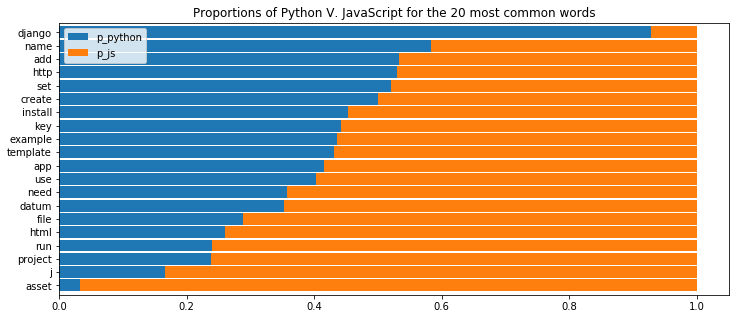

In [34]:
# figure out the percentage of language distribution
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_js=word_counts.js / word_counts['all']
        )
 .sort_values(by='all')
 [['p_python',
   'p_js'
  ]]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True, figsize=(12,5), width=.9))

plt.title('Proportions of Python V. JavaScript for the 20 most common words')

In [35]:
word_counts[(word_counts.python > 10) & (word_counts.js > 10)]\
    .assign(ratio=lambda df: df.python / df.js)\
    .sort_values(by='ratio')

,python,js,all,ratio
deploy,16,99,115,0.161616
config,13,77,90,0.168831
script,20,108,128,0.185185
j,37,185,222,0.200000
pull,11,52,63,0.211538
command,19,76,95,0.250000
update,13,51,64,0.254902
build,27,105,132,0.257143
google,26,100,126,0.260000
event,15,51,66,0.294118


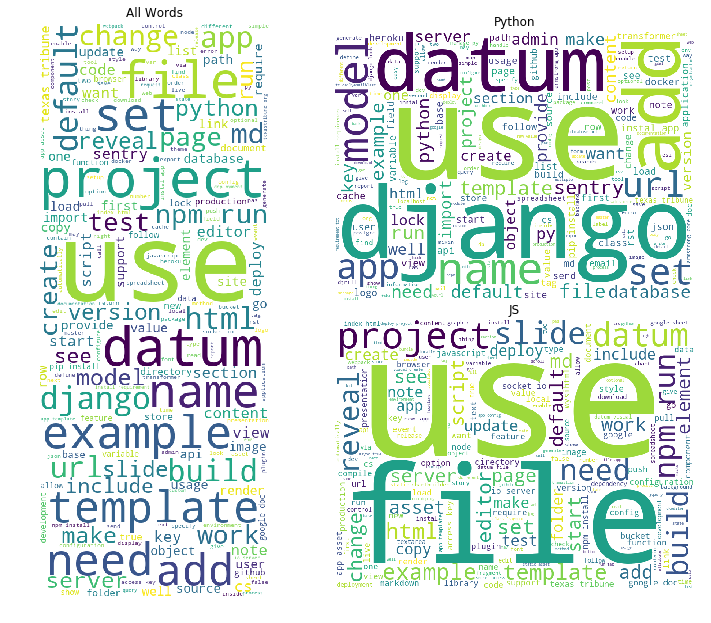

In [36]:
# Creating word clouds for python-associated words, javascript-related words,
# and a combination of all words together:
all_cloud = WordCloud(background_color='white', height=1000, width=400, random_state=123).generate(' '.join(all_words))
python_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(python_words))
js_cloud = WordCloud(background_color='white', height=600, width=800, random_state=123).generate(' '.join(js_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(python_cloud)
axs[2].imshow(js_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Python')
axs[2].set_title('JS')

for ax in axs: ax.axis('off')

In [37]:
# Creating bigrams for each python and javascript words.
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(20))

top_20_python_bigrams.head()

(instal, app)       36
(pip, install)      34
(texas, tribune)    24
(http, www)         23
(manage, py)        23
dtype: int64

In [38]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_words, 2))
                      .value_counts()
                      .head(20))

top_20_js_bigrams.head()

(npm, run)        89
(reveal, j)       43
(google, doc)     40
(npm, install)    36
(socket, io)      35
dtype: int64

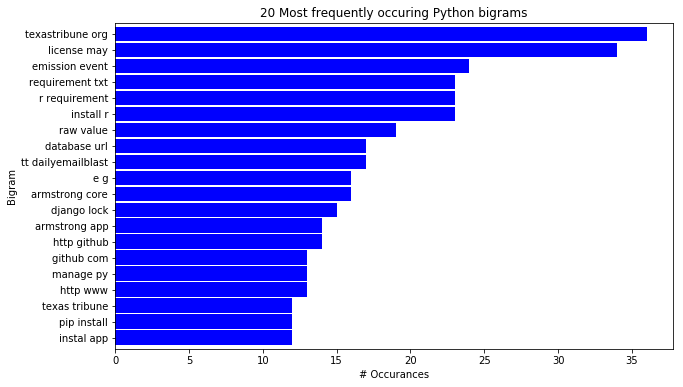

In [39]:
# Charting python bigrams:
top_20_python_bigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
# TODO: fix the labels which are in reversed order
ticks, _ = plt.yticks()
labels = top_20_python_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

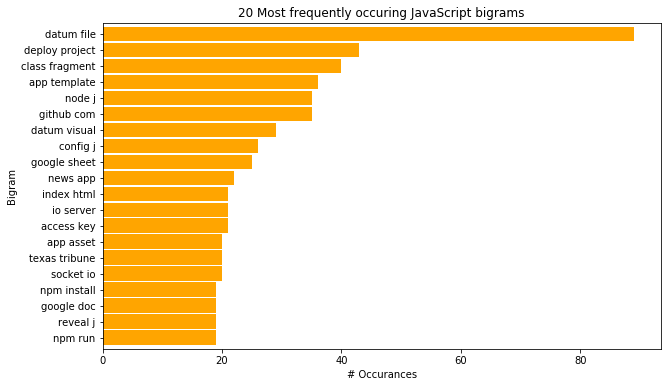

In [40]:
# Charting javascript bigrams:
top_20_js_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
# TODO: fix the labels which are in reversed order
ticks, _ = plt.yticks()
labels = top_20_js_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

Text(0.5, 1.0, 'Top 20 Python Bigrams')

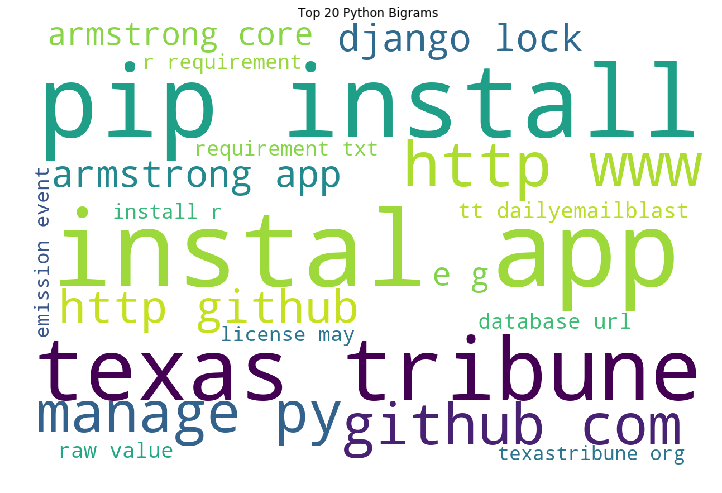

In [41]:
# Creating wordclouds for python bigrams:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=1200, height=800, random_state=123).generate_from_frequencies(data)

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 Python Bigrams')

Text(0.5, 1.0, 'Top 20 JavaScript Bigrams')

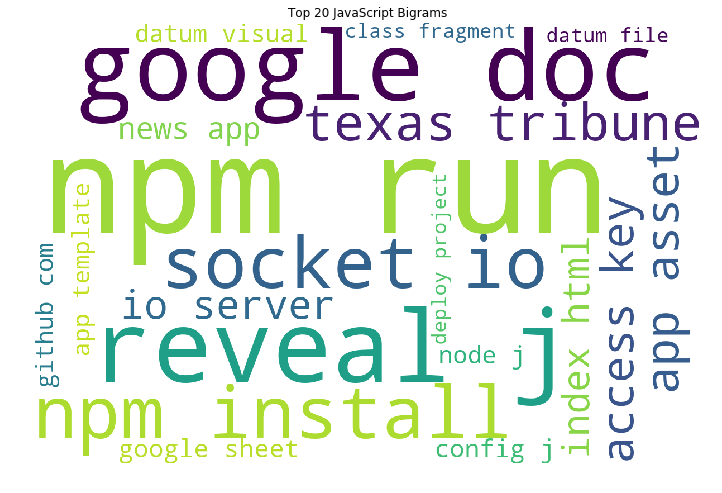

In [42]:
# Creating wordclouds for javascript bigrams:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=1200, height=800, random_state=123).generate_from_frequencies(data)
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis('off')
plt.title('Top 20 JavaScript Bigrams')

In [43]:
# Creating python trigrams:
top_20_python_trigrams = (pd.Series(nltk.ngrams(python_words, 3))
                      .value_counts()
                      .head(20))

top_20_python_trigrams.head()

(http, github, com)          19
(pip, install, r)            13
(install, r, requirement)    13
(rio, grande, county)        11
(armstrong, core, arm)       11
dtype: int64

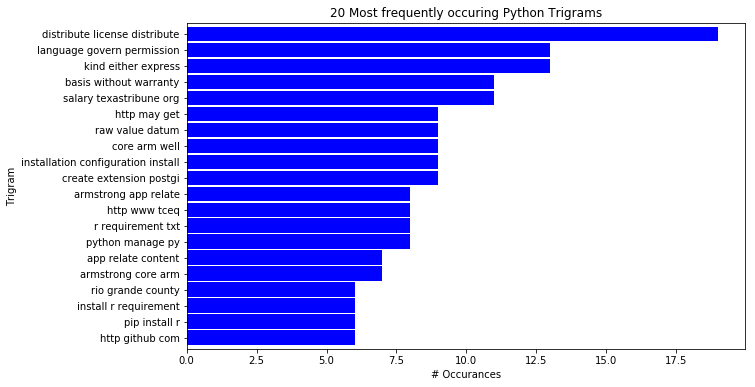

In [44]:
# Charting python trigrams:
top_20_python_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring Python Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_python_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

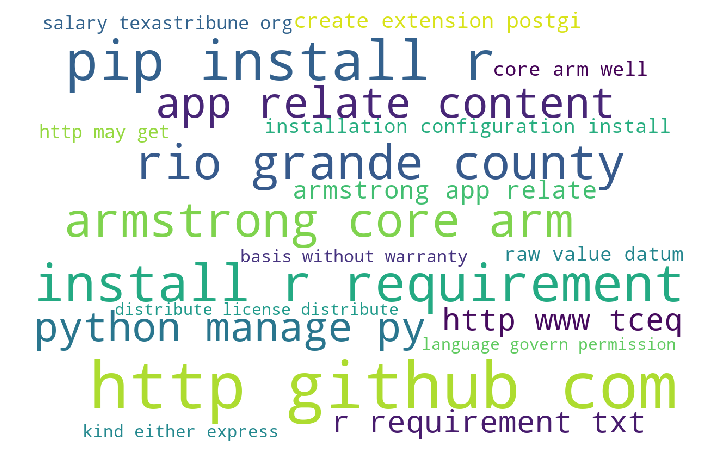

In [45]:
# Creating wordcloud for python trigrams:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_python_trigrams.to_dict().items()}
img_python_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_python_tri)
plt.axis('off')

In [46]:
# Creating javascript trigrams:
top_20_js_trigrams = (pd.Series(nltk.ngrams(js_words, 3))
                      .value_counts()
                      .head(20))

top_20_js_trigrams.head()

(socket, io, server)     25
(j, async, true)         18
(http, github, com)      18
(secret, access, key)    16
(npm, run, deploy)       16
dtype: int64

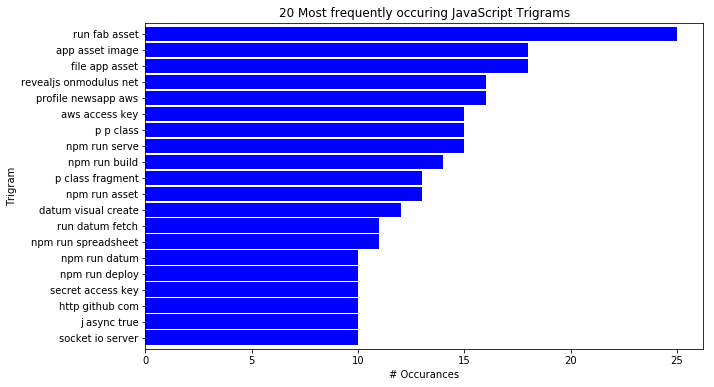

In [47]:
# Charting javascript trigrams:
top_20_js_trigrams.sort_values().plot.barh(color='blue', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring JavaScript Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_js_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

(-0.5, 1199.5, 799.5, -0.5)

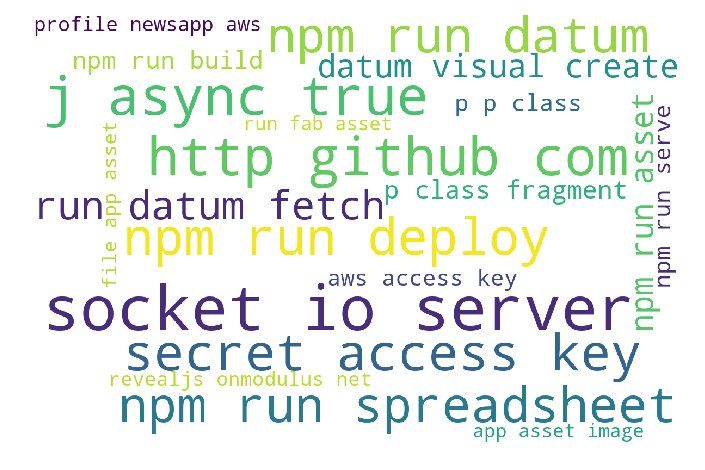

In [48]:
# Creating wordcloud for javascript trigrams:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_js_trigrams.to_dict().items()}
img_js_tri = WordCloud(background_color='white', width=1200, height=800).generate_from_frequencies(data)
plt.figure(figsize=(12, 8))
plt.imshow(img_js_tri)
plt.axis('off')

## QUESTION:
### _Do different languages use a different number of unique words?_

In [49]:
# Creating a new dataframe to answer this question.
df3 = df.copy()

In [50]:
df3.head()

,text,language
1,md software collect donation nonprofit integra...,Python
2,md datum visual create tool generate scaffoldi...,JavaScript
5,md texas tribune file app app power file syste...,JavaScript
9,md thermometer,Python
10,md wall query salesforce opportunity informati...,Python


In [51]:
# Creating separate python df to answer this question:
df3_python = df3[df3.language == 'Python']
df3_python.shape

(68, 2)

In [52]:
# Creating separate javascript df to answer this question:
df3_js = df3[df3.language == 'JavaScript']
df3_js.shape

(60, 2)

In [53]:
def flatten(lofl):     
    for i in lofl: 
        if type(i) == list: 
            flatten(i) 
        else: 
            output.append(i)
    return output

In [54]:
string_python = []
for text in df3_python.text.tolist():
    string_python.append(text.split())

In [55]:
output = []
words_in_python = pd.Series(flatten(string_python))
print(len(set(words_in_python)))

2305


In [56]:
string_js = []
for text in df3_js.text.tolist():
    string_js.append(text.split())

In [57]:
output = []
words_in_js = pd.Series(flatten(string_js))
print(len(set(words_in_js)))

2258


## ANSWER:
### _Yes, but not by much (relatively speaking). Repositories that are primarily written in Python have readme files that are on average 47 words more than those written in JavaScript._

## SENTIMENT ANALYSIS

In [78]:
afinn = Afinn()

In [79]:
afinn.score('This is amazingly awesome')

4.0

In [80]:
df.head()

,text,language
1,software collect donation nonprofit integrate ...,Python
2,datum visual create tool generate scaffolding ...,JavaScript
5,texas tribune file app app power file system t...,JavaScript
9,thermometer,Python
10,wall query salesforce opportunity information ...,Python


In [81]:
df['sentiment'] = df.text.apply(afinn.score)

In [82]:
df.head(20)

,text,language,sentiment
1,software collect donation nonprofit integrate ...,Python,19.0
2,datum visual create tool generate scaffolding ...,JavaScript,108.0
5,texas tribune file app app power file system t...,JavaScript,0.0
9,thermometer,Python,0.0
10,wall query salesforce opportunity information ...,Python,5.0
11,scuole italian school public school setup proj...,Python,7.0
14,geoip super simple node js base deployment get...,JavaScript,3.0
15,talk online comment break open source comment ...,JavaScript,27.0
16,rst tx salary django application generate use ...,Python,22.0
18,file,Python,0.0


In [83]:
df.groupby('language').sentiment.mean()

language
JavaScript    16.550000
Python         8.485294
Name: sentiment, dtype: float64

In [121]:
df_negative = df[df.sentiment < 0].reset_index().drop(columns=['index'])
df_negative

,text,language,sentiment
0,pass poison texas industrial polluter rarely f...,JavaScript,-4.0
1,iped importer purpose make easy interact iped ...,Python,-1.0
2,rst sentry heroku sentry realtime event loggin...,Python,-2.0
3,pymviewer single page site testing pym js embe...,JavaScript,-3.0
4,tx lobby early alpha datum two main source dat...,Python,-17.0
5,rst officeledger officeledger provide simple m...,Python,-3.0
6,rst django sentry sentry provide generic inter...,Python,-4.0


In [122]:
df_negative.iloc[4]['text']

"tx lobby early alpha datum two main source datum list register lobbyist year http www ethic state tx dfs loblist htm coversheet lobbyist activie report la http www ethic state tx dfs search lobby html name come source datum coversheet detail information name information lobby interest come registration form information enter hand hard use without scrub way de duplicate lobbying interest way regenerate lobbyist 's interest base raw registration datum store form amend often update good idea go back year get run set environment variable one way env file django setting module example project setting database url postgre tx lobby haystack url http optional want geocode https geoservice tamu edu service geocode webservice tamu api key f dcc b aa deb cf use autoenv source env activate install dep pip install r requirement txt npm install get database run postgre instruction createdb tx lobby simple postgre setup phd createdb complicated database url pip install postdoc inital migration make 

### INSIGHT:
#### _On the surface, JS repos appear to be more positive that Python repos. However, we hypothesize that the reason for is because JavaScript is a very use-case-specific tool, web-development. Python repos deal more with the data is associated with the actual content of the news, which can and often do contain negatively scoring words._

# MODEL

## Train/Test Split

In [58]:
# Creating additional dfs for modeling purposes:
dfx1 = df.copy() # Logistic Regression with Cross Validation
dfx2 = df.copy() # KNN
dfx3 = df.copy() # Decision Tree
dfx4 = df.copy() # Random Forest

## 1. Logistic Regression With Cross Validation

In [59]:
tfidf1 = TfidfVectorizer()
X1 = tfidf1.fit_transform(dfx1.text)
y1 = dfx1.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=.3)

train1 = pd.DataFrame(dict(actual=y1_train))
test1 = pd.DataFrame(dict(actual=y1_test))

lm = LogisticRegressionCV(random_state=123).fit(X1_train, y1_train)

train1['predicted'] = lm.predict(X1_train)
test1['predicted'] = lm.predict(X1_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [60]:
print('Accuracy: {:.2%}'.format(accuracy_score(train1.actual, train1.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train1.predicted, train1.actual))
print('---')
print(classification_report(train1.actual, train1.predicted))

Accuracy: 94.38%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript          44       4
Python               1      40
---
              precision    recall  f1-score   support

  JavaScript       0.92      0.98      0.95        45
      Python       0.98      0.91      0.94        44

   micro avg       0.94      0.94      0.94        89
   macro avg       0.95      0.94      0.94        89
weighted avg       0.95      0.94      0.94        89



## 2.  K-Nearest Neighbors Model

In [62]:
tfidf2 = TfidfVectorizer()
X2 = tfidf2.fit_transform(dfx2.text)
y2 = dfx2.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=.3)

train2 = pd.DataFrame(dict(actual=y2_train))
test2 = pd.DataFrame(dict(actual=y2_test))

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X2_train, y2_train)

y2_pred = knn.predict(X2_train)
y2_pred_proba = knn.predict_proba(X2_train)

In [63]:
print('Accuracy: {:.2%}'.format(knn.score(X2_train, y2_train)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(y2_train, y2_pred))
print('---')
print(classification_report(y2_train, y2_pred))

Accuracy: 82.02%
---
Confusion Matrix
col_0       JavaScript  Python
language                      
JavaScript          43       0
Python              16      30
---
              precision    recall  f1-score   support

  JavaScript       0.73      1.00      0.84        43
      Python       1.00      0.65      0.79        46

   micro avg       0.82      0.82      0.82        89
   macro avg       0.86      0.83      0.82        89
weighted avg       0.87      0.82      0.82        89



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 3.  Decision Tree model

In [64]:
tfidf3 = TfidfVectorizer()
X3 = tfidf3.fit_transform(dfx3.text)
y3 = dfx3.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=.3)

train3 = pd.DataFrame(dict(actual=y3_train))
test3 = pd.DataFrame(dict(actual=y3_test))

clf = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=123)

clf.fit(X3_train, y3_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [65]:
y3_pred = clf.predict(X3_train)
y3_pred[0:5]

array(['Python', 'JavaScript', 'Python', 'JavaScript', 'Python'],
      dtype=object)

In [66]:
y3_pred_proba = clf.predict_proba(X3_train)
y3_pred_proba[0:5]

array([[0.18      , 0.82      ],
       [1.        , 0.        ],
       [0.18      , 0.82      ],
       [0.71428571, 0.28571429],
       [0.18      , 0.82      ]])

#### Evaluate Model
- *Compute the Accuracy*
- *Accuracy:  number of correct predictions over the number of total instances that have been evaluated.*

In [67]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X3_train, y3_train)))

Accuracy of Decision Tree classifier on training set: 0.85


In [68]:
confusion_matrix(y3_train, y3_pred)

array([[34,  9],
       [ 4, 42]])

In [69]:
y3_train.value_counts()

Python        46
JavaScript    43
Name: language, dtype: int64

In [70]:
labels = sorted(y3_train.unique())

In [71]:
pd.DataFrame(confusion_matrix(y3_train, y3_pred), index=labels, columns=labels)

,JavaScript,Python
JavaScript,34,9
Python,4,42


In [72]:
print(classification_report(y3_train, y3_pred))

              precision    recall  f1-score   support

  JavaScript       0.89      0.79      0.84        43
      Python       0.82      0.91      0.87        46

   micro avg       0.85      0.85      0.85        89
   macro avg       0.86      0.85      0.85        89
weighted avg       0.86      0.85      0.85        89



- **Precision:** the higher this number is, the more you were able to pinpoint all positives correctly.  If this is a low score, you predicted a lot of positives where there were none.
    - tp / (tp + fp)


- **Recall:** if this score is high, you didn’t miss a lot of positives. But as it gets lower, you are not predicting the positives that are actually there.
    - tp / (tp + fn)


- **f1-score:** The balanced harmonic mean of Recall and Precision, giving both metrics equal weight. The higher the F-Measure is, the better.


- **Support:** number of occurrences of each class in where y is true.

## 4. Random Forest

In [73]:
tfidf4 = TfidfVectorizer()
X4 = tfidf4.fit_transform(dfx4.text)
y4 = dfx4.language

# We decided not to stratify because the sample is already balanced
# We also decided to split 70/30
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=.3)

train4 = pd.DataFrame(dict(actual=y4_train))
test4 = pd.DataFrame(dict(actual=y4_test))

rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [74]:
rf.fit(X4_train, y4_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [75]:
y4_pred = rf.predict(X4_train)
y4_pred_proba = rf.predict_proba(X4_train)

In [76]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X4_train, y4_train)))

Accuracy of random forest classifier on training set: 0.84


In [77]:
print(confusion_matrix(y4_train, y4_pred))

[[23 14]
 [ 0 52]]


In [78]:
print(classification_report(y4_train, y4_pred))

              precision    recall  f1-score   support

  JavaScript       1.00      0.62      0.77        37
      Python       0.79      1.00      0.88        52

   micro avg       0.84      0.84      0.84        89
   macro avg       0.89      0.81      0.82        89
weighted avg       0.88      0.84      0.83        89



## Logistic Regression with Cross Validation on the TEST SET

In [79]:
print('Accuracy: {:.2%}'.format(accuracy_score(test1.actual, test1.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test1.predicted, test1.actual))
print('---')
print(classification_report(test1.actual, test1.predicted))

Accuracy: 89.74%
---
Confusion Matrix
actual      JavaScript  Python
predicted                     
JavaScript          13       2
Python               2      22
---
              precision    recall  f1-score   support

  JavaScript       0.87      0.87      0.87        15
      Python       0.92      0.92      0.92        24

   micro avg       0.90      0.90      0.90        39
   macro avg       0.89      0.89      0.89        39
weighted avg       0.90      0.90      0.90        39



## Build a function that will take in the text of a README file, and makes a prediction of language.

In [80]:
def predict(unknown_text):
    return lm.predict(tfidf1.transform([unknown_text]))[0]

In [81]:
# Plug in web address below to predict primary language of readme file:
corpus = get_github_repo('https://github.com/airbnb/javascript')['readme']
predict(corpus)

'Python'

# NEXT ITERATION WITHLIST

- Consider bringing in the other languages in addition to the first dominant language.
- Consider processing the other sliver languages like Jupyter notebooks, dockerfiles, shell, and makefiles.
- Consider using Yellowbrick to visualize.
- Use textacy, spacy-based library.